The code is adopted from https://notes.quantecon.org/submission/5b32e9b0b9eab00015b89f7d

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import networkx as nx

Data obtained from: https://oec.world/en/resources/data/ <p>AJG Simoes, CA Hidalgo. The Economic Complexity Observatory: An Analytical Tool for Understanding the Dynamics of Economic Development. Workshops at the Twenty-Fifth AAAI Conference on Artificial Intelligence. (2011)</p>

In [2]:
fl = "year_origin_hs07_6.tsv.bz2"
data = pd.read_csv(fl, converters={'sitc':str}, compression="bz2", delimiter="\t") #Import SITC codes as strings to preserve formatting
data.head()

year origin   hs07  export_val  import_val  export_rca  import_rca
0  2008    ago  10110      5750.0    269237.0    0.001019    0.150395
1  2008    ago  10190         NaN    551325.0         NaN    0.394349
2  2008    ago  10210         NaN   8231053.0         NaN    8.340120
3  2008    ago  10290         NaN    863490.0         NaN    0.125381
4  2008    ago  10310         NaN      5031.0         NaN    0.025567

Building proximity network

In [7]:
cntry_export = data[["year", "origin", "export_val"]].groupby(by=["year", "origin"]).sum()
cntry_export.head(n=2)

export_val
year origin              
2008 abw     5.110882e+09
     afg     2.084431e+08

In [12]:
data["cntry_export"] = data[["year", "origin", "export_val"]].groupby(by=["year", "origin"]).transform(np.sum)
data["prod_export"] = data[["year", "hs07", "export_val"]].groupby(by=["year", "hs07"]).transform(np.sum)
data["world_export"] = data[["year", "export_val"]].groupby(by=["year"]).transform(np.sum)

In [15]:
data["rca"] = (data["export_val"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])
data.head()

year origin   hs07  export_val  import_val  export_rca  import_rca  \
0  2008    ago  10110      5750.0    269237.0    0.001019    0.150395   
1  2008    ago  10190         NaN    551325.0         NaN    0.394349   
2  2008    ago  10210         NaN   8231053.0         NaN    8.340120   
3  2008    ago  10290         NaN    863490.0         NaN    0.125381   
4  2008    ago  10310         NaN      5031.0         NaN    0.025567   

   cntry_export   prod_export  world_export       rca  
0  5.947048e+10  1.457503e+09  1.536086e+13  0.001019  
1  5.947048e+10  1.138238e+09  1.536086e+13       NaN  
2  5.947048e+10  8.035078e+08  1.536086e+13       NaN  
3  5.947048e+10  5.607035e+09  1.536086e+13       NaN  
4  5.947048e+10  1.602051e+08  1.536086e+13       NaN

In [43]:
#-Generate Yearly RCA Mcp Matrices and store them in a Dictionary-#
rca = {}
# Remove stateless origins
data = data[data.origin.apply(lambda x: "xx" not in x)]
for year in data.year.unique():
    yr = data[data.year == year].copy().set_index(['origin', 'hs07']).unstack('hs07')['rca']
    rca[year] = yr

rca[2008].head()

hs07      10110   10190   10210   10290   10310   10391   10392   10410   \
origin                                                                     
abw     0.009108     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
afg          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ago     0.001019     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
aia          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
alb          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

hs07      10420     10511   ...  961620    961700  961800    970110  \
origin                      ...                                       
abw          NaN  0.086343  ...     NaN  0.074818     NaN  0.002462   
afg          NaN       NaN  ...     NaN       NaN     NaN       NaN   
ago     0.004885       NaN  ...     NaN       NaN     NaN  0.001649   
aia          NaN       NaN  ...     NaN       NaN     NaN  0.106899   
alb          NaN  1.871420  ...     NaN       NaN     NaN  0.008249   

hs07        970190  970200    970300    970400    970500    970600  
origin                                                              
abw       0.094776     NaN  0.001850  0.014310       NaN       NaN  
afg            NaN     NaN  1.270798       NaN       NaN  5.105427  
ago            NaN     NaN  0.000278       NaN       NaN       NaN  
aia     101.672198     NaN       NaN       NaN       NaN  1.251582  
alb       0.424718     NaN  0.016390  4.489951  1.082119       NaN  

[5 rows x 5046 columns]

In [44]:
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)
mcp[2012].head()

hs07    10110   10190   10210   10290   10310   10391   10392   10410   \
origin                                                                   
abw        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
afg        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ago        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
aia        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
alb        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

hs07    10420   10511   ...  961620  961700  961800  970110  970190  970200  \
origin                  ...                                                   
abw        0.0     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0   
afg        0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
ago        0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
aia        0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0     1.0   
alb        0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

hs07    970300  970400  970500  970600  
origin                                  
abw        0.0     0.0     0.0     0.0  
afg        0.0     0.0     0.0     0.0  
ago        0.0     0.0     0.0     0.0  
aia        1.0     0.0     0.0     0.0  
alb        0.0     1.0     0.0     0.0  

[5 rows x 5045 columns]

In [56]:
@jit(nopython=True)
def coexport_probability(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    return proximity

def proximity_matrix_numba(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    col_sums = mcp.sum().values
    data = mcp.T.values#as_matrix()
    proximity = coexport_probability(data, num_products, col_sums) #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

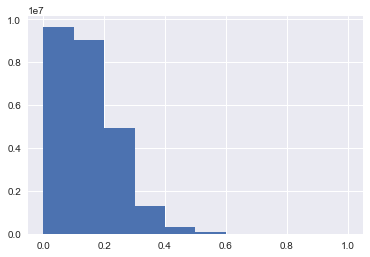

In [57]:
prox = proximity_matrix_numba(mcp[2015])
prox.unstack().describe()
prox.unstack().hist()

In [58]:
proximity = {}
for year in mcp.keys():
    proximity[year] = proximity_matrix_numba(mcp[year])
print(proximity)

{2008: productcode2    10110     10190     10210     10290     10310     10391   \
productcode1                                                               
10110         1.000000  0.347826  0.222222  0.161290  0.157895  0.000000   
10190         0.347826  1.000000  0.407407  0.322581  0.347826  0.173913   
10210         0.222222  0.407407  1.000000  0.516129  0.407407  0.185185   
10290         0.161290  0.322581  0.516129  1.000000  0.258065  0.193548   
10310         0.157895  0.347826  0.407407  0.258065  1.000000  0.315789   
...                ...       ...       ...       ...       ...       ...   
970200        0.222222  0.260870  0.148148  0.129032  0.263158  0.111111   
970300        0.130435  0.217391  0.148148  0.064516  0.173913  0.000000   
970400        0.133333  0.200000  0.200000  0.133333  0.177778  0.111111   
970500        0.138889  0.277778  0.222222  0.166667  0.166667  0.027778   
970600        0.130435  0.217391  0.111111  0.064516  0.130435  0.000000   

prod

Plot the product space per year

In [60]:
prox = proximity[2015]
prox.head()

productcode2    10110     10190     10210     10290     10310     10391   \
productcode1                                                               
10110         1.000000  0.384615  0.214286  0.142857  0.111111  0.153846   
10190         0.384615  1.000000  0.285714  0.238095  0.192308  0.192308   
10210         0.214286  0.285714  1.000000  0.404762  0.464286  0.178571   
10290         0.142857  0.238095  0.404762  1.000000  0.214286  0.119048   
10310         0.111111  0.192308  0.464286  0.214286  1.000000  0.277778   

productcode2    10392     10410     10420     10511   ...    961620    961700  \
productcode1                                          ...                       
10110         0.166667  0.136364  0.105263  0.210526  ...  0.153846  0.076923   
10190         0.230769  0.192308  0.153846  0.342105  ...  0.076923  0.000000   
10210         0.428571  0.178571  0.107143  0.315789  ...  0.035714  0.071429   
10290         0.261905  0.404762  0.285714  0.261905  ...  0.000000  0.000000   
10310         0.611111  0.045455  0.000000  0.236842  ...  0.055556  0.055556   

productcode2    961800    970110    970190    970200    970300    970400  \
productcode1                                                               
10110         0.000000  0.166667  0.161290  0.235294  0.130435  0.162162   
10190         0.038462  0.230769  0.193548  0.230769  0.153846  0.216216   
10210         0.035714  0.071429  0.096774  0.142857  0.107143  0.216216   
10290         0.071429  0.095238  0.119048  0.095238  0.119048  0.166667   
10310         0.055556  0.041667  0.032258  0.166667  0.043478  0.108108   

productcode2    970500    970600  
productcode1                      
10110         0.109375  0.090909  
10190         0.203125  0.151515  
10210         0.125000  0.090909  
10290         0.140625  0.047619  
10310         0.062500  0.030303  

[5 rows x 5029 columns]

In [61]:
edge_list = prox.unstack()

In [62]:
#-Construct Sequence of node pairs as a pd.Series
edge_list.head()

productcode2  productcode1
10110         10110           1.000000
              10190           0.384615
              10210           0.214286
              10290           0.142857
              10310           0.111111
dtype: float64

In [63]:
#-Remove Self Loops-#
edge_list = edge_list[edge_list != 1.0] #TODO: do this operation properly to compare node1 == node2

In [64]:
edge_list.head()

productcode2  productcode1
10110         10190           0.384615
              10210           0.214286
              10290           0.142857
              10310           0.111111
              10391           0.153846
dtype: float64

In [65]:
#-Construct DataFrame-#
edge_list = edge_list.reset_index()
edge_list.columns = ["P1","P2","weight"]

In [66]:
edge_list["inv_weight"] = 1 - edge_list['weight'] #Useful when working with minimum spanning tree in networkx

In [67]:
edge_list.head()

P1     P2    weight  inv_weight
0  10110  10190  0.384615    0.615385
1  10110  10210  0.214286    0.785714
2  10110  10290  0.142857    0.857143
3  10110  10310  0.111111    0.888889
4  10110  10391  0.153846    0.846154

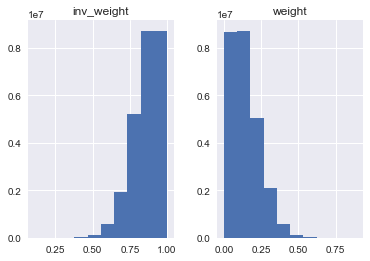

In [69]:
edge_list[["weight","inv_weight"]].hist();

In [70]:
import networkx as nx

In [71]:
#-Construct the complete network-#
g = nx.from_pandas_edgelist(edge_list, source="P1", target="P2", edge_attr=["weight", "inv_weight"])
print("# of Nodes: {}".format(g.number_of_nodes()))
print("# of Edges: {}".format(g.number_of_edges()))

# of Nodes: 5029
# of Edges: 12642898


In [72]:
mst = nx.minimum_spanning_tree(g, weight='inv_weight') #Maximum Spanning Tree
print("# of Nodes: {}".format(mst.number_of_nodes()))
print("# of Edges: {}".format(mst.number_of_edges()))

# of Nodes: 5029
# of Edges: 5028


In [74]:
#-Build Maximum Spanning Tree + Keep Edges > 0.50-#
ps = nx.Graph()
#Add MST ('weight' attribute only)
for u,v,w in mst.edges(data=True):
    ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})
#Add Edges > 0.50
for u,v,w in g.edges(data=True):
    if w['weight'] >= 0.37:
        ps.add_edge(u,v,attr_dict={'weight' : w["weight"]})

In [75]:
print("# of Nodes: {}".format(ps.number_of_nodes()))
print("# of Edges: {}".format(ps.number_of_edges()))

# of Nodes: 5029
# of Edges: 289299


In [744]:
ps_nodes = pd.read_csv("PS_SITC_nodes.csv", converters={'sitc' : str}, 
                       names=["sitc","PCI","Color"])
ps_edges = pd.read_csv("PS_SITC_edges.csv", converters={'sourceid' : str, 'targetid' : str},
                       names=["sourceid", "targetid","targetx","width"])

In [745]:
ps_nodes.head()

sitc    PCI Color
0  530310 -2.864     r
1  630510 -2.623     r
2  530500 -2.087     r
3  520210 -2.014     r
4  520299 -1.753     r

In [746]:
ps_nodes.shape

(308, 3)

In [747]:
def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df[column+"_scaled"] = (df[column] - min_value) / (max_value - min_value)
    return df

In [748]:
#-Check Entry-#
ps_nodes[ps_nodes.sitc == "251720"]

sitc    PCI Color
116  251720  0.279     b

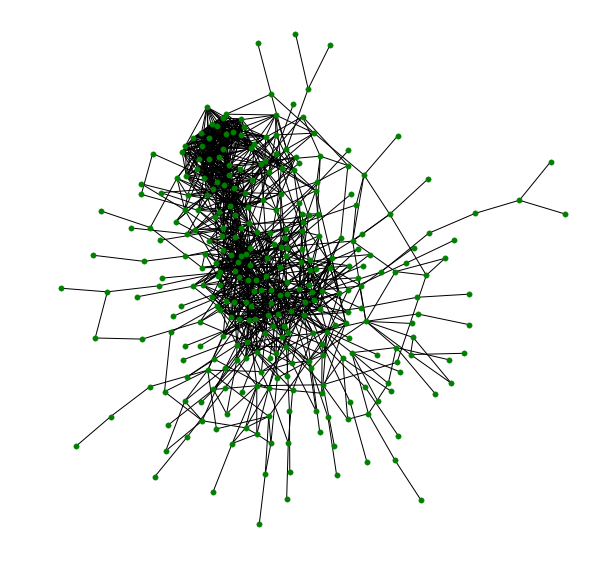

In [759]:
import matplotlib.pyplot as plt
pos = nx.kamada_kawai_layout(ps)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
limits=plt.axis('off')
nx.draw_networkx(ps, pos, ax=ax, node_size=30, with_labels=False, width=1, node_color='green')
plt.savefig("productspace1.png")

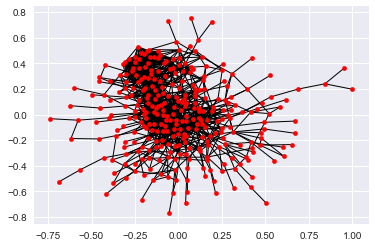

In [593]:
pos = nx.kamada_kawai_layout(ps)

nx.draw_networkx(ps,pos, node_size=20, width=1, with_labels=False)


import pylab as plt
plt.savefig('test.png')